テイラー展開は滑らかな関数の一点における値や微分の値を使ったべき級数によって元の関数を表す方法でした。

$$
f(x) = f(a) + f'(a)(x - a) + \frac{f''(a)}{2!}\left(x-a\right)^2 + \frac{f'''(a)}{3!}\left(x-a\right)^3 + \cdots
$$

これを2点以上に拡張したテイラー展開が存在していて、特に2点でテイラー展開を行うものは2点テイラー展開と呼ばれているそうです。

なんで2点でテイラー展開したくなるのかというと、普通のテイラー展開だと1点における2n階までの微分値を使わないと達成できない近似精度を2点テイラー展開だと2点におけるn階までの微分値で達成できたりするそうなのですが（スゴイ！）[^1]、個人的には2点でテイラー展開することで区分的に定義された関数も近似できるのが面白いなと思いました。

テイラー展開は1点の周りにおける情報しか使わないので通常近似できる範囲はその1点の近くまでです。特に関数が折れ線だったり、[ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))のように各領域によって違う関数の組み合わせで表されている場合には領域を区分する点をまたいで近似できる範囲を拡張することができません。そこで2点テイラー展開を使えば区分する点をまたいだ2点の周りで展開することによりそれぞれの点の周りの情報を使ってテイラー展開よりも近似できる範囲を拡張することができるのです。以下の定理はこのことをより正確に表しています[^2]。

----

Theorem. $f$を${\mathbb R}$上の以下のように表される関数とする。

$$
f(x) = \begin{cases} p(x)\ \ x \in [0, \infty) \\ q(x)\ \ x \in (-\infty, 0) \end{cases}
$$

ここで$p, q$は高々$m$次の多項式とする。この時、もし$p(0)=q(0)$であるならば$f(x)$は-1, 1において2点テイラー展開可能であり、$p_{f,\{-1, 1\}(n, n)}(x)$をエルミート補間多項式だとすると以下が成り立つ。

$$
\underset{n \rightarrow \infty}{\lim}p_{f,\{-1, 1\}(n, n)}(x)=f(x), \forall x \in \left(-\sqrt 2, \sqrt 2\right)
$$

----

ところでまだ2点テイラー展開の定義をしていませんでした。2点テイラー展開は多項式補間の考え方を経由して定義されます。  
（以下の説明は[^2]の導入部分を大いに参考にしています）

十分になめらかな実数値関数$f(x)$に対して$n$個の点$X = \{x_0,\dots,x_n\}$とそれぞれの点に対応する自然数$k_i(0\leq i\leq n)$が与えられた時、高々$m(=k_0+\cdots+k_n-1)$次の多項式$p_{f,X(k_0,\dots,k_n)}(x)$が存在して

$$
p^{(j)}_{f,X(k_0,\dots,k_n)}(x_i) = f^{(j)}(x_i), 0\leq j \leq k_i-1, 0 \leq i \leq n
$$

を満たす時、$p_{f,X(k_0,\dots,k_n)}(x)$を$f(x)$のエルミート補間多項式と呼びます。

もし$f(x)$が一点$x_0$の周りで無限回微分可能であり、ある正の実数$\rho$が存在して

$$
\underset{n \rightarrow \infty}{\lim} p_{f,X(n)}(x) = f(x), \forall x \in (x_0-\rho, x_0+\rho)
$$

となるならば$f(x)$は同じ範囲でテイラー展開可能であることが分かります。

この事実を発展させて$n$点テイラー展開は以下のように定義されます。

----

$f$をある区間$I$で定義された実数値関数とし、$I$に含まれる$n$個の点$X=\{x_0,\dots x_{n-1}\}$で$f$が無限回微分可能であったとする。もし

$$
\underset{m \rightarrow \infty}{\lim} p_{f,X(m,\dots,m)}(x) = f(x), \forall x \in I
$$

が成り立つならば$f$は$I$において$n$点テイラー展開可能であるという。

----

$n$点テイラー展開の具体的な形は、エルミート補間多項式の一般公式が知られているので[^3]そちらから計算可能でしょう。特に2点テイラー展開の場合の級数の計算式は以下のようにできるとTwitterで教えてもらいました[^4]。（そもそも2点テイラー展開を知ったきっかけも、このnotebookを書こうと思ったのも島田さんのTweetに触発されてでした。感謝🙏）

## 数値実験
比較のためにまずは通常のテイラー展開を実装してみます

In [1]:
{-# LANGUAGE RankNTypes #-}

import Data.Number.Symbolic

import Numeric.AD
import Numeric.AD.Mode.Tower


-- 階乗
fact :: Int -> Int
fact n = product [1..n]


-- テイラー展開
taylorSeries :: Fractional a
             => Int                                          -- この次数以下の級数まで展開する
             -> (forall s. AD s (Tower a) -> AD s (Tower a)) -- テイラー展開する関数
             -> a                                            -- 展開する点
             -> (a -> a)                                     -- 展開後の級数
taylorSeries n f a x = sum $ take n $ coefficients |*| polynomials
  where
  coefficients = diffs f a |/| factorials      -- f(a)/0!, f'(a)/1!, f''(a)/2!, f'''(a)/3!, ...
  factorials = map (fromIntegral . fact) [0..] -- 0!, 1!, 2!, 3!, ...
  polynomials = ((x - a)^) <$> [0..]           -- 1, x-a, (x-a)^2, (x-a)^3, ...
  (|/|) = zipWith (/)
  (|*|) = zipWith (*)


taylorSeries 4 exp 0 (var "x")

1.0+x+0.5*x*x+0.16666666666666666*x*x*x

4次までの指数関数のテイラー展開をちゃんと計算できていますね

$$
1 + x + \frac{x^2}{2!} + \frac{x^3}{3!}
$$

次は2点テイラー展開を実装してみましょう

In [2]:
-- 2点テイラー展開
twoPointTaylorSeries :: Fractional a
                     => Int                                          -- この次数以下の級数まで展開する
                     -> (forall s. AD s (Tower a) -> AD s (Tower a)) -- テイラー展開する関数
                     -> a                                            -- 展開する点1
                     -> a                                            -- 展開する点2
                     -> (a -> a)                                     -- 展開後の級数
twoPointTaylorSeries n f a b x = seriesA + seriesB
  where
  seriesA = (x - a) ^ n * sum (take n $ coefB |*| polyB)
  seriesB = (x - b) ^ n * sum (take n $ coefA |*| polyA)
  fa x = f x / (x - auto b)^n        -- A(x)
  fb x = f x / (x - auto a)^n        -- B(x)
  coefA = diffs fa a |/| factorials  -- A(a)/0!, A'(a)/1!, A''(a)/2!, A'''(a)/3!, ...
  coefB = diffs fb b |/| factorials  -- B(b)/0!, B'(b)/1!, B''(b)/2!, B'''(b)/3!, ...
  polyA = ((x - a)^) <$> [0..]       -- 1, x-a, (x-a)^2, (x-a)^3, ...
  polyB = ((x - b)^) <$> [0..]       -- 1, x-b, (x-b)^2, (x-b)^3, ...
  factorials = map (fromIntegral . fact) [0..] -- 0!, 1!, 2!, 3!, ...
  (|/|) = zipWith (/)
  (|*|) = zipWith (*)


twoPointTaylorSeries 2 id (-1) 1 (var "x") -- id ≡ f(x) = x

0.25*(1.0+x)*(1.0+x)+(-0.25)*(-1.0+x)*(-1.0+x)

式が複雑になるので$f(x)=x$という単純な関数を展開して確かめてみました。式を整理するとちゃんと正しい答えになってるのが分かります。

それでは実際に関数を近似してみましょう

まずは

$$
\frac{1}{1+x^2}
$$

という関数を展開してみましょう

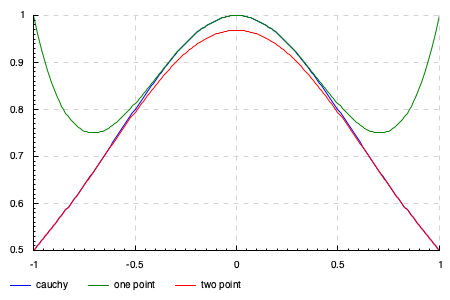

In [3]:
import Graphics.Rendering.Chart.Easy

cauchy :: Floating a => a -> a
cauchy x = 1 / (1 + x^2)

domain :: [Double]
domain = map (\n -> fromIntegral n / 100) [-100..100]

toRenderable $ do
    plot (line "cauchy"    [flip map domain $ \x -> (x, cauchy x)])
    plot (line "one point" [flip map domain $ \x -> (x, taylorSeries 5 cauchy 0 x)])
    plot (line "two point" [flip map domain $ \x -> (x, twoPointTaylorSeries 5 cauchy (-1) 1 x)])

青線が元の関数、緑線が$0$周りでの5次までのテイラー展開、赤線が$-1, 1$周りでの5次までの2点テイラー展開です。同じ次数までの展開ですが2点テイラー展開のほうがより高い精度で近似できているのが分かります

次に区分的に定義された関数であるReLUを展開してみましょう

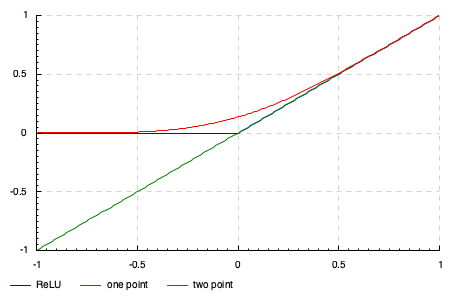

In [4]:
relu :: (Ord a, Floating a) => a -> a
relu = max 0

toRenderable $ do
    plot (line "ReLU"      [flip map domain $ \x -> (x, relu x)])
    plot (line "one point" [flip map domain $ \x -> (x, taylorSeries 5 relu 1 x)])
    plot (line "two point" [flip map domain $ \x -> (x, twoPointTaylorSeries 5 relu (-1) 1 x)])

テイラー展開は$1$の周りで展開していますがやはり0以下で関数が変わっていることには対応できていません。一方で2点テイラー展開は$1$の周りに加えて$-1$の周りの情報もつかえているのでReLUの形をより正確に近似できているのが分かります。

## 参考文献
- [1] Estes, R. H., and E. R. Lancaster. "Two-point Taylor series expansions." (1966).
- [2] Kitahara, Kazuaki, Taizo Chiyonobu, and Hirokazu Tsukamoto. "A note on two point Taylor expansion." International Journal of Pure and Applied Mathematics 75.3 (2012): 327-338.
- [3] 鈴木 実, "エルミート補間の一般公式（Generalized Hermite interpolation）" <http://totoha.web.fc2.com/Hermite_interpolation.pdf>
- [4] <https://twitter.com/KS_Mathematics/status/1279807348391854080>